# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = './input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

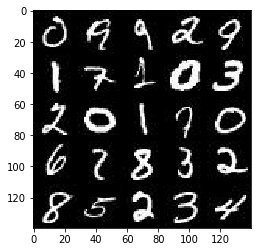

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray');

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

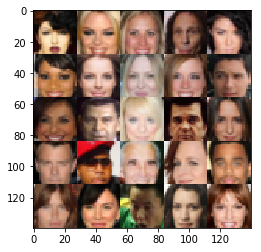

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'));

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [8]:
keep_prob = 0.7
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    def leaky_relu(h, alpha=0.2):
        return tf.maximum(alpha * h, h)
    
    def fully_connected_normalized_discriminator(prev_layer, input_units):
        layer = tf.reshape(prev_layer, shape=(-1, input_units))
        logits = tf.layers.dense(layer, units=1,activation=None)
        out = tf.sigmoid(logits)
        return out, logits
        
    def conv2d_normalized(prev_layer, num_units=64, k_size=5, strides=2, alpha=0.2,
                          needNormal=True,
                          needDrop=True,
                          keep_prob=0.5):
        layer = tf.layers.conv2d(prev_layer, num_units, k_size, strides,  
                                 use_bias=False, 
                                 activation=None,
                                 kernel_initializer=tf.truncated_normal_initializer(stddev = 0.05),
                                 padding='same')
        if needNormal:
            layer = tf.layers.batch_normalization(layer, training=True)                
        layer = leaky_relu(layer, alpha)
        if needDrop:
            layer = tf.layers.dropout(layer, keep_prob, training=True)
        return layer
    
    with tf.variable_scope('discriminator', reuse=reuse):
        k_size = 5
        strides = 2
        first_layer_depth = 64
        alpha = 0.2
        layer_depth = first_layer_depth
        deep_layer = conv2d_normalized(images, 
                                       num_units=layer_depth, 
                                       k_size=k_size,
                                       keep_prob=keep_prob,
                                       strides=strides, 
                                       alpha=alpha, needNormal=False, needDrop=False)
        layer_depth = int(layer_depth*strides)
        deep_layer = conv2d_normalized(deep_layer, 
                                       num_units=layer_depth, 
                                       k_size=k_size, 
                                       keep_prob=keep_prob,
                                       strides=strides, 
                                       alpha=alpha)
        
        
        layer_depth = int(layer_depth*strides)
        deep_layer = conv2d_normalized(deep_layer, 
                                       num_units=layer_depth, 
                                       k_size=k_size, 
                                       keep_prob=keep_prob,
                                       strides=strides, 
                                       alpha=alpha)
        final_layer_shape = deep_layer.get_shape().as_list()
        input_units = final_layer_shape[1]*final_layer_shape[2]*final_layer_shape[3]
        out, logits = fully_connected_normalized_discriminator(deep_layer, input_units=input_units)
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    def leaky_relu(h, alpha):
        return tf.maximum(alpha * h, h)
    
    def fully_connected_normalized_generator(z, num_units, shape, alpha=0.2):
        x = tf.layers.dense(z, units=num_units,activation=None)
        layer = tf.reshape(x, shape)
        batch_normalized_output = tf.layers.batch_normalization(layer, training=is_train)
        return leaky_relu(batch_normalized_output, alpha)
            
    def conv2d_transpose_normalized(prev_layer, num_units, k_size, strides, training, alpha=0.2):
        layer = tf.layers.conv2d_transpose(prev_layer, 
                                 num_units, 
                                 k_size, 
                                 strides, 
                                 padding='same', 
                                 kernel_initializer=tf.truncated_normal_initializer(stddev = 0.05),
                                 use_bias=False, 
                                 activation=None)
        batch_normalized_output = tf.layers.batch_normalization(layer, training=training)                
        return leaky_relu(batch_normalized_output, alpha)

    reuse = True if is_train == False else False
    
    with tf.variable_scope('generator', reuse=reuse):
        k_size = 5
        strides = 2
        first_layer_depth = 512
        alpha = 0.2
        # First fully connected layer
        layer_depth = first_layer_depth
        shape = [-1, 7, 7, layer_depth]
        deep_layer = fully_connected_normalized_generator(z, 
                                                 num_units=shape[1]*shape[2]*shape[3], 
                                                 shape=shape, 
                                                 alpha=alpha)                                               
        layer_depth = int(layer_depth/strides)
        deep_layer = conv2d_transpose_normalized(deep_layer, 
                                                 num_units=layer_depth, 
                                                 k_size=k_size, 
                                                 strides=strides, 
                                                 training=is_train, 
                                                 alpha=alpha)                        
        layer_depth = out_channel_dim
        logits = tf.layers.conv2d_transpose(deep_layer, 
                                            filters=layer_depth,  
                                            kernel_size=k_size, 
                                            strides=strides, 
                                            padding='same', 
                                            use_bias=False, 
                                            activation=None)   
        out = tf.tanh(logits)
        return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [14]:
import sys
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # Create the network
    print(data_shape, z_dim, learning_rate, beta1)
    n_batches = int(data_shape[0]/batch_size)  
    print("Total number of training iterations is {}.".format(n_batches) )
    print()
    samples, losses = [], []
       
    input_real, input_z, input_lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_real,input_z,data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    steps = 0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Resize images ( -1 to 1)
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})  
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                if steps % 10 == 0 or steps == 1 or steps == n_batches:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                if steps % 100 == 0 or steps == 1 or steps == n_batches:
                    show_generator_output(sess, 
                                          n_images = 20, 
                                          input_z = input_z, 
                                          out_channel_dim=data_shape[3], 
                                          image_mode=data_image_mode)
                    print("{:.3f}% of works have been done.".format(steps*100.0/n_batches))
                    print()
        print("End of training.")              

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

In [15]:
keep_prob = 0.5

(60000, 28, 28, 1) 128 0.0003 0.3
Total number of training iterations is 937.

Epoch 1/2... Discriminator Loss: 3.2468... Generator Loss: 0.1288


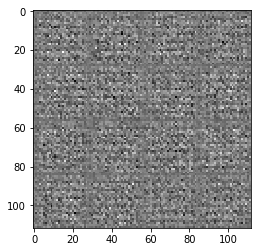

0.107% of works have been done.

Epoch 1/2... Discriminator Loss: 2.4065... Generator Loss: 0.4756
Epoch 1/2... Discriminator Loss: 2.0704... Generator Loss: 0.7820
Epoch 1/2... Discriminator Loss: 2.3257... Generator Loss: 0.4584
Epoch 1/2... Discriminator Loss: 1.8651... Generator Loss: 0.5229
Epoch 1/2... Discriminator Loss: 1.7259... Generator Loss: 0.7767
Epoch 1/2... Discriminator Loss: 1.8770... Generator Loss: 0.5949
Epoch 1/2... Discriminator Loss: 1.8470... Generator Loss: 1.0330
Epoch 1/2... Discriminator Loss: 1.8738... Generator Loss: 0.4409
Epoch 1/2... Discriminator Loss: 1.6498... Generator Loss: 1.0114
Epoch 1/2... Discriminator Loss: 1.5769... Generator Loss: 0.6656


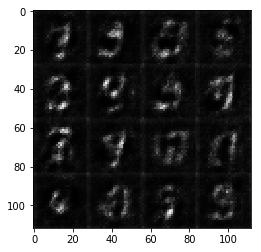

10.672% of works have been done.

Epoch 1/2... Discriminator Loss: 1.7905... Generator Loss: 0.7922
Epoch 1/2... Discriminator Loss: 1.7133... Generator Loss: 0.6449
Epoch 1/2... Discriminator Loss: 1.6333... Generator Loss: 0.7042
Epoch 1/2... Discriminator Loss: 1.6165... Generator Loss: 0.6316
Epoch 1/2... Discriminator Loss: 1.6097... Generator Loss: 1.0034
Epoch 1/2... Discriminator Loss: 1.7842... Generator Loss: 0.9596
Epoch 1/2... Discriminator Loss: 1.7530... Generator Loss: 0.3787
Epoch 1/2... Discriminator Loss: 1.6057... Generator Loss: 0.8375
Epoch 1/2... Discriminator Loss: 1.6871... Generator Loss: 1.2125
Epoch 1/2... Discriminator Loss: 1.5494... Generator Loss: 0.6684


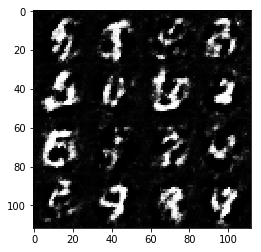

21.345% of works have been done.

Epoch 1/2... Discriminator Loss: 1.5109... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.6230... Generator Loss: 0.6291
Epoch 1/2... Discriminator Loss: 1.6689... Generator Loss: 0.8711
Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.9808
Epoch 1/2... Discriminator Loss: 1.5371... Generator Loss: 0.6726
Epoch 1/2... Discriminator Loss: 1.3317... Generator Loss: 1.1016
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 1.1355
Epoch 1/2... Discriminator Loss: 1.3949... Generator Loss: 0.5782
Epoch 1/2... Discriminator Loss: 1.4441... Generator Loss: 1.1838
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 0.9269


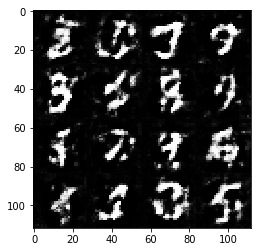

32.017% of works have been done.

Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.7319
Epoch 1/2... Discriminator Loss: 1.4580... Generator Loss: 1.1785
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 1.0066
Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 0.8089
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 0.5542
Epoch 1/2... Discriminator Loss: 1.5708... Generator Loss: 1.3486
Epoch 1/2... Discriminator Loss: 1.3909... Generator Loss: 0.8443
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 1.1541
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.6571
Epoch 1/2... Discriminator Loss: 1.4693... Generator Loss: 0.4963


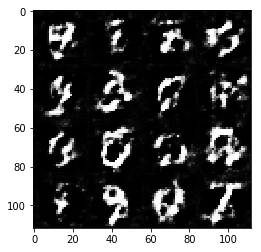

42.689% of works have been done.

Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.7942
Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 0.6984
Epoch 1/2... Discriminator Loss: 1.4137... Generator Loss: 1.1206
Epoch 1/2... Discriminator Loss: 1.4159... Generator Loss: 1.0354
Epoch 1/2... Discriminator Loss: 1.4832... Generator Loss: 1.4322
Epoch 1/2... Discriminator Loss: 1.5650... Generator Loss: 0.9335
Epoch 1/2... Discriminator Loss: 1.4619... Generator Loss: 1.4014
Epoch 1/2... Discriminator Loss: 1.4739... Generator Loss: 0.5836
Epoch 1/2... Discriminator Loss: 1.2871... Generator Loss: 0.7539
Epoch 1/2... Discriminator Loss: 1.5675... Generator Loss: 0.8190


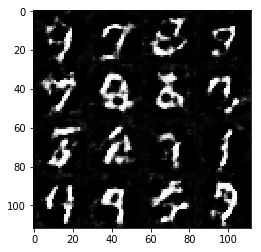

53.362% of works have been done.

Epoch 1/2... Discriminator Loss: 1.7187... Generator Loss: 1.4550
Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 0.7499
Epoch 1/2... Discriminator Loss: 1.5273... Generator Loss: 0.5170
Epoch 1/2... Discriminator Loss: 1.5207... Generator Loss: 1.1471
Epoch 1/2... Discriminator Loss: 1.4299... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 1.6678... Generator Loss: 1.1994
Epoch 1/2... Discriminator Loss: 1.5649... Generator Loss: 1.1363
Epoch 1/2... Discriminator Loss: 1.4941... Generator Loss: 0.7893
Epoch 1/2... Discriminator Loss: 1.7649... Generator Loss: 0.3672
Epoch 1/2... Discriminator Loss: 1.6669... Generator Loss: 0.4844


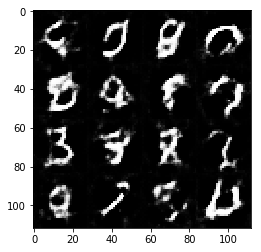

64.034% of works have been done.

Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 0.6021
Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 0.5647
Epoch 1/2... Discriminator Loss: 1.5681... Generator Loss: 1.4104
Epoch 1/2... Discriminator Loss: 1.3840... Generator Loss: 0.9992
Epoch 1/2... Discriminator Loss: 1.3708... Generator Loss: 0.8389
Epoch 1/2... Discriminator Loss: 1.5227... Generator Loss: 1.1756
Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 0.8986
Epoch 1/2... Discriminator Loss: 1.6858... Generator Loss: 0.4683
Epoch 1/2... Discriminator Loss: 1.4578... Generator Loss: 0.5488
Epoch 1/2... Discriminator Loss: 1.3345... Generator Loss: 0.8747


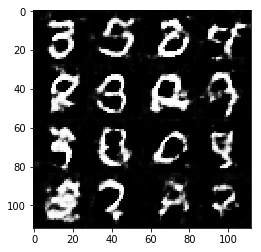

74.707% of works have been done.

Epoch 1/2... Discriminator Loss: 1.4712... Generator Loss: 0.8322
Epoch 1/2... Discriminator Loss: 1.5673... Generator Loss: 0.4527
Epoch 1/2... Discriminator Loss: 1.4488... Generator Loss: 0.9680
Epoch 1/2... Discriminator Loss: 1.7956... Generator Loss: 0.3645
Epoch 1/2... Discriminator Loss: 1.4470... Generator Loss: 0.6598
Epoch 1/2... Discriminator Loss: 1.6402... Generator Loss: 0.5400
Epoch 1/2... Discriminator Loss: 1.4568... Generator Loss: 0.8482
Epoch 1/2... Discriminator Loss: 1.5703... Generator Loss: 0.5702
Epoch 1/2... Discriminator Loss: 1.5225... Generator Loss: 0.8806
Epoch 1/2... Discriminator Loss: 1.4700... Generator Loss: 0.7867


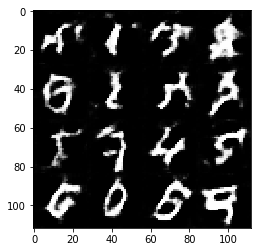

85.379% of works have been done.

Epoch 1/2... Discriminator Loss: 1.3599... Generator Loss: 0.7251
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 1.1375
Epoch 1/2... Discriminator Loss: 1.4705... Generator Loss: 0.6338
Epoch 1/2... Discriminator Loss: 1.6033... Generator Loss: 0.9087
Epoch 1/2... Discriminator Loss: 1.5190... Generator Loss: 0.6732
Epoch 1/2... Discriminator Loss: 1.4031... Generator Loss: 0.9047
Epoch 1/2... Discriminator Loss: 1.4700... Generator Loss: 1.0759
Epoch 1/2... Discriminator Loss: 1.4156... Generator Loss: 0.6803
Epoch 1/2... Discriminator Loss: 1.6709... Generator Loss: 0.4055
Epoch 1/2... Discriminator Loss: 1.5526... Generator Loss: 0.7384


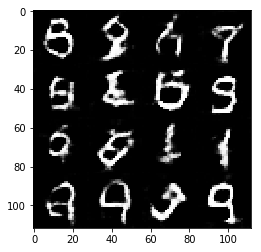

96.051% of works have been done.

Epoch 1/2... Discriminator Loss: 1.3192... Generator Loss: 0.9103
Epoch 1/2... Discriminator Loss: 1.4563... Generator Loss: 0.8544
Epoch 1/2... Discriminator Loss: 1.5348... Generator Loss: 1.0832
Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.6507


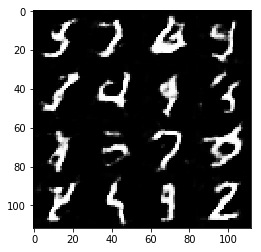

100.000% of works have been done.

Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 0.6671
Epoch 2/2... Discriminator Loss: 1.5192... Generator Loss: 0.9034
Epoch 2/2... Discriminator Loss: 1.4743... Generator Loss: 0.5737
Epoch 2/2... Discriminator Loss: 1.4362... Generator Loss: 0.6919
Epoch 2/2... Discriminator Loss: 1.4418... Generator Loss: 0.7356
Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 0.7168
Epoch 2/2... Discriminator Loss: 1.5171... Generator Loss: 0.5456


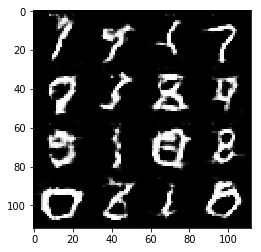

106.724% of works have been done.

Epoch 2/2... Discriminator Loss: 1.5626... Generator Loss: 0.4976
Epoch 2/2... Discriminator Loss: 1.6708... Generator Loss: 0.3607
Epoch 2/2... Discriminator Loss: 1.4463... Generator Loss: 0.7457
Epoch 2/2... Discriminator Loss: 1.5186... Generator Loss: 1.1113
Epoch 2/2... Discriminator Loss: 1.4158... Generator Loss: 0.8992
Epoch 2/2... Discriminator Loss: 1.2320... Generator Loss: 0.6550
Epoch 2/2... Discriminator Loss: 1.7249... Generator Loss: 0.3563
Epoch 2/2... Discriminator Loss: 1.3393... Generator Loss: 0.7049
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.7745
Epoch 2/2... Discriminator Loss: 1.5480... Generator Loss: 0.7634


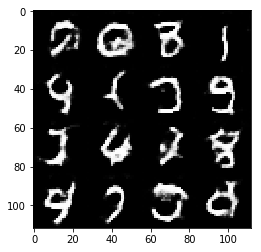

117.396% of works have been done.

Epoch 2/2... Discriminator Loss: 1.6319... Generator Loss: 1.0905
Epoch 2/2... Discriminator Loss: 1.4892... Generator Loss: 0.6950
Epoch 2/2... Discriminator Loss: 1.3080... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 0.5920
Epoch 2/2... Discriminator Loss: 1.4983... Generator Loss: 0.5913
Epoch 2/2... Discriminator Loss: 1.4516... Generator Loss: 0.7324
Epoch 2/2... Discriminator Loss: 1.4012... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 1.4537... Generator Loss: 0.6908
Epoch 2/2... Discriminator Loss: 1.4684... Generator Loss: 0.4881
Epoch 2/2... Discriminator Loss: 1.4574... Generator Loss: 0.4934


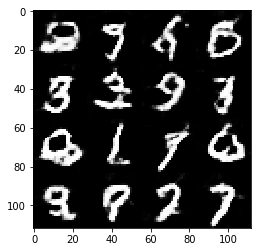

128.068% of works have been done.

Epoch 2/2... Discriminator Loss: 1.4005... Generator Loss: 0.6899
Epoch 2/2... Discriminator Loss: 1.3366... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 1.4779... Generator Loss: 0.6646
Epoch 2/2... Discriminator Loss: 2.0589... Generator Loss: 0.1697
Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 0.7918
Epoch 2/2... Discriminator Loss: 1.5125... Generator Loss: 0.7715
Epoch 2/2... Discriminator Loss: 1.4896... Generator Loss: 0.5179
Epoch 2/2... Discriminator Loss: 1.3164... Generator Loss: 0.7363
Epoch 2/2... Discriminator Loss: 1.4941... Generator Loss: 0.5078
Epoch 2/2... Discriminator Loss: 1.6312... Generator Loss: 1.5790


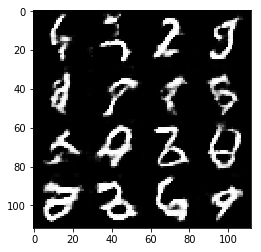

138.741% of works have been done.

Epoch 2/2... Discriminator Loss: 1.2476... Generator Loss: 0.5784
Epoch 2/2... Discriminator Loss: 1.5519... Generator Loss: 0.6620
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 0.7275
Epoch 2/2... Discriminator Loss: 1.4705... Generator Loss: 0.5086
Epoch 2/2... Discriminator Loss: 1.5912... Generator Loss: 0.4041
Epoch 2/2... Discriminator Loss: 1.3578... Generator Loss: 0.9422
Epoch 2/2... Discriminator Loss: 1.4006... Generator Loss: 0.7213
Epoch 2/2... Discriminator Loss: 1.4957... Generator Loss: 0.6704
Epoch 2/2... Discriminator Loss: 1.6099... Generator Loss: 0.4319
Epoch 2/2... Discriminator Loss: 1.4815... Generator Loss: 1.1459


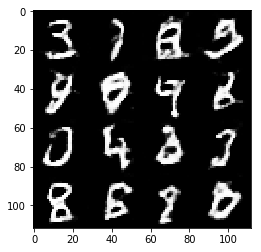

149.413% of works have been done.

Epoch 2/2... Discriminator Loss: 1.3265... Generator Loss: 0.6155
Epoch 2/2... Discriminator Loss: 1.5407... Generator Loss: 0.8949
Epoch 2/2... Discriminator Loss: 1.2936... Generator Loss: 0.6919
Epoch 2/2... Discriminator Loss: 1.4544... Generator Loss: 0.5214
Epoch 2/2... Discriminator Loss: 1.4713... Generator Loss: 0.6616
Epoch 2/2... Discriminator Loss: 1.3038... Generator Loss: 0.7459
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.8888
Epoch 2/2... Discriminator Loss: 1.3924... Generator Loss: 0.8730
Epoch 2/2... Discriminator Loss: 1.3576... Generator Loss: 0.5151
Epoch 2/2... Discriminator Loss: 1.2663... Generator Loss: 0.8215


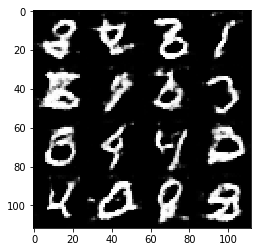

160.085% of works have been done.

Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.6859
Epoch 2/2... Discriminator Loss: 1.4366... Generator Loss: 0.5349
Epoch 2/2... Discriminator Loss: 1.3504... Generator Loss: 0.6139
Epoch 2/2... Discriminator Loss: 1.3705... Generator Loss: 0.8317
Epoch 2/2... Discriminator Loss: 1.5514... Generator Loss: 0.4967
Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 1.0501
Epoch 2/2... Discriminator Loss: 1.3536... Generator Loss: 0.6699
Epoch 2/2... Discriminator Loss: 1.5222... Generator Loss: 0.4172
Epoch 2/2... Discriminator Loss: 1.8734... Generator Loss: 0.2716
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 0.9908


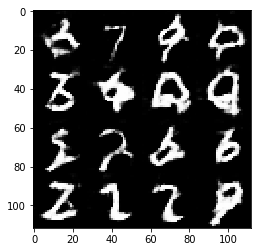

170.758% of works have been done.

Epoch 2/2... Discriminator Loss: 1.4134... Generator Loss: 0.6837
Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 0.7607
Epoch 2/2... Discriminator Loss: 1.6987... Generator Loss: 1.3411
Epoch 2/2... Discriminator Loss: 1.1824... Generator Loss: 0.8738
Epoch 2/2... Discriminator Loss: 1.3179... Generator Loss: 0.8638
Epoch 2/2... Discriminator Loss: 1.4400... Generator Loss: 1.0795
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 0.8688
Epoch 2/2... Discriminator Loss: 1.3575... Generator Loss: 0.8438
Epoch 2/2... Discriminator Loss: 1.5281... Generator Loss: 0.6939
Epoch 2/2... Discriminator Loss: 1.6108... Generator Loss: 0.8351


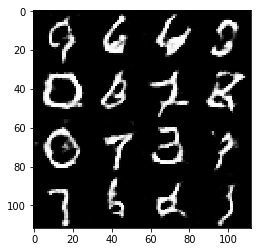

181.430% of works have been done.

Epoch 2/2... Discriminator Loss: 1.3955... Generator Loss: 0.4542
Epoch 2/2... Discriminator Loss: 1.6114... Generator Loss: 0.5022
Epoch 2/2... Discriminator Loss: 1.6089... Generator Loss: 0.3929
Epoch 2/2... Discriminator Loss: 1.4371... Generator Loss: 0.6570
Epoch 2/2... Discriminator Loss: 1.2631... Generator Loss: 0.5130
Epoch 2/2... Discriminator Loss: 1.3422... Generator Loss: 0.7099
Epoch 2/2... Discriminator Loss: 1.3632... Generator Loss: 1.1011
Epoch 2/2... Discriminator Loss: 1.1841... Generator Loss: 0.8766
Epoch 2/2... Discriminator Loss: 1.2218... Generator Loss: 0.7057
Epoch 2/2... Discriminator Loss: 1.2602... Generator Loss: 0.7316


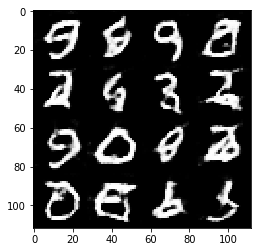

192.102% of works have been done.

Epoch 2/2... Discriminator Loss: 1.3070... Generator Loss: 0.7944
Epoch 2/2... Discriminator Loss: 1.5308... Generator Loss: 0.4953
Epoch 2/2... Discriminator Loss: 1.2766... Generator Loss: 0.6186
Epoch 2/2... Discriminator Loss: 1.3569... Generator Loss: 1.0094
Epoch 2/2... Discriminator Loss: 1.4498... Generator Loss: 0.7306
Epoch 2/2... Discriminator Loss: 1.4343... Generator Loss: 0.6292
Epoch 2/2... Discriminator Loss: 1.2432... Generator Loss: 0.9135
End of training.


In [16]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

(202599, 28, 28, 3) 100 0.0003 0.5
Total number of training iterations is 3165.

Epoch 1/1... Discriminator Loss: 3.8966... Generator Loss: 0.0804


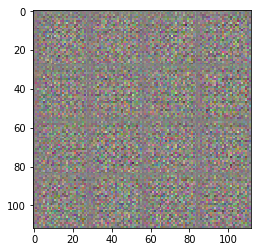

0.032% of works have been done.

Epoch 1/1... Discriminator Loss: 2.8164... Generator Loss: 0.3381
Epoch 1/1... Discriminator Loss: 2.1686... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.8498... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.6550... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.7715... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.8843... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 2.1012... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 2.1867... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 2.2383... Generator Loss: 0.5344


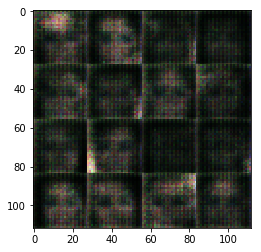

3.160% of works have been done.

Epoch 1/1... Discriminator Loss: 1.7775... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.8637... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 2.1333... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.7796... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 2.0480... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.9868... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.7854... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.7550... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.6181... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.7667... Generator Loss: 0.7350


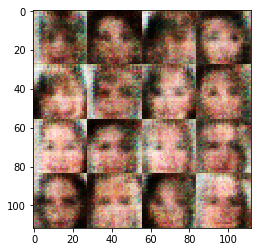

6.319% of works have been done.

Epoch 1/1... Discriminator Loss: 1.7816... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.7573... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.7883... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.7991... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.6264... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.6770... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.6024... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.6377... Generator Loss: 0.7697


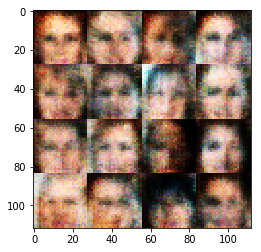

9.479% of works have been done.

Epoch 1/1... Discriminator Loss: 1.7361... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.6380... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.6418... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.6025... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.6471... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.5464... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.6216... Generator Loss: 0.6020


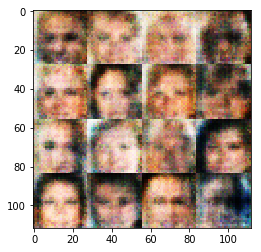

12.638% of works have been done.

Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.5779
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8713


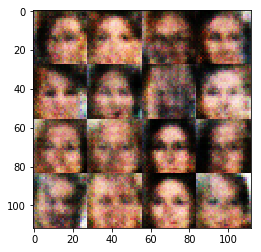

15.798% of works have been done.

Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 1.6930
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7403


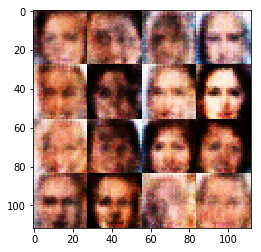

18.957% of works have been done.

Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 1.1962
Epoch 1/1... Discriminator Loss: 1.6534... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 1.4346
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.7505... Generator Loss: 0.3678
Epoch 1/1... Discriminator Loss: 1.5988... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 0.6411


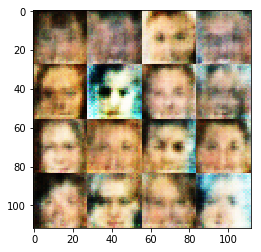

22.117% of works have been done.

Epoch 1/1... Discriminator Loss: 1.5663... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.5904... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.5791... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.6292... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.6021... Generator Loss: 0.6635


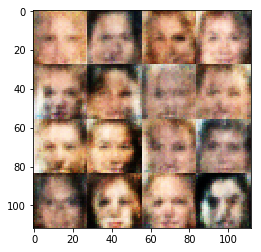

25.276% of works have been done.

Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.5165... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.5304... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.6966


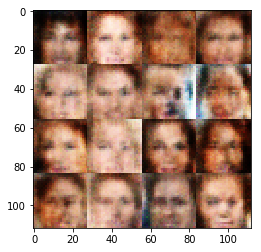

28.436% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.5837... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7494


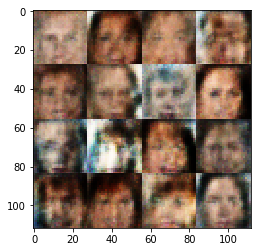

31.596% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.7159


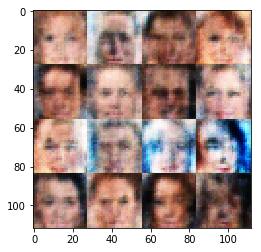

34.755% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.6771


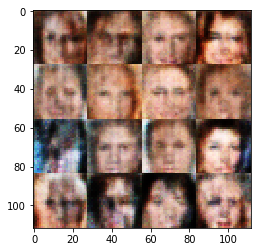

37.915% of works have been done.

Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7219


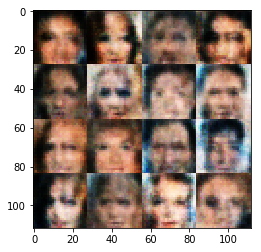

41.074% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6563


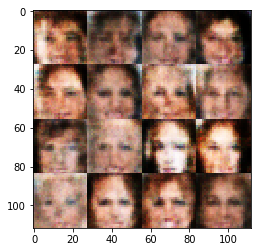

44.234% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6643


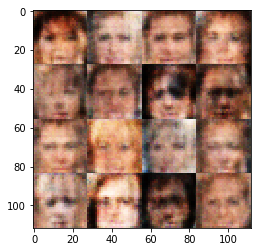

47.393% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7407


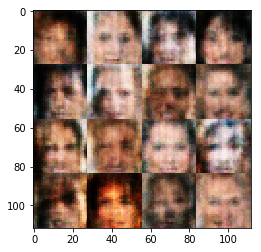

50.553% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6904


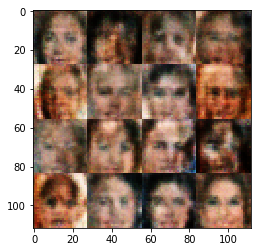

53.712% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7003


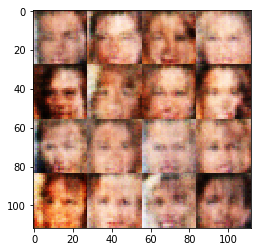

56.872% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.6256


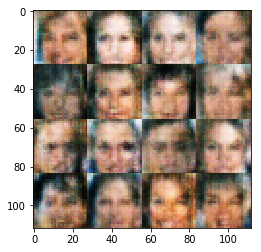

60.032% of works have been done.

Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.6716


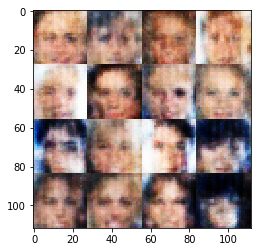

63.191% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6771


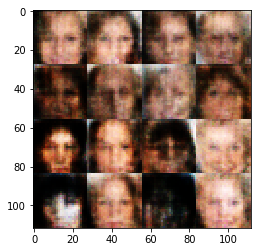

66.351% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.6986


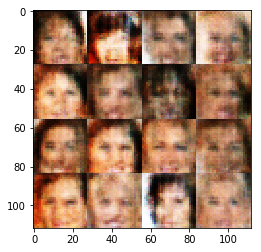

69.510% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7072


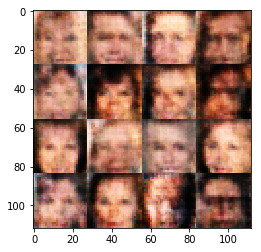

72.670% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7027


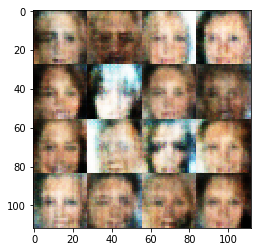

75.829% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.6797


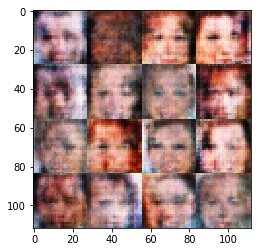

78.989% of works have been done.

Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.6375


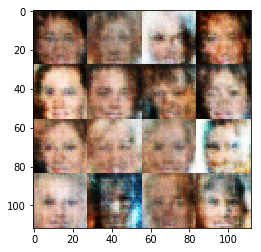

82.148% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6833


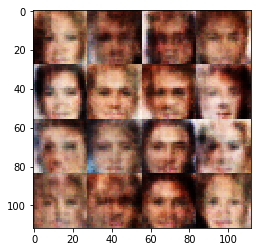

85.308% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.6495


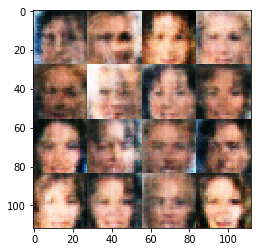

88.468% of works have been done.

Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7125


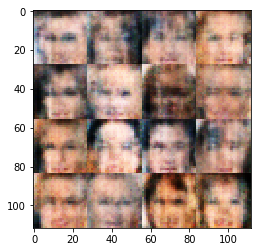

91.627% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7102


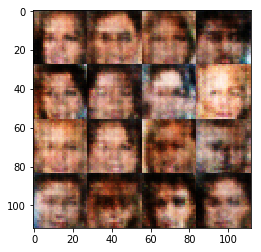

94.787% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6970


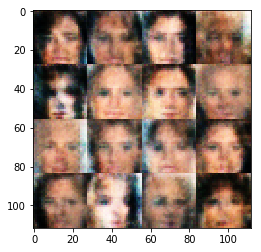

97.946% of works have been done.

Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6483


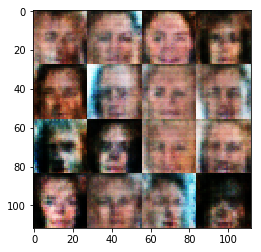

100.000% of works have been done.

End of training.


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。